In [15]:
import pandas as pd
import duckdb
import seaborn as sns

In [3]:
users = pd.read_csv('users.csv')
course_users = pd.read_csv('course_users.csv')
courses = pd.read_csv('courses.csv')
course_types = pd.read_csv('course_types.csv')
lessons = pd.read_csv('lessons.csv')
subjects = pd.read_csv('subjects.csv')
cities = pd.read_csv('cities.csv')
homework_done = pd.read_csv('homework_done.csv')
homework = pd.read_csv('homework.csv')
homework_lessons = pd.read_csv('homework_lessons.csv')
user_roles = pd.read_csv('user_roles.csv') 

In [5]:
user_roles

,id,name
0,1,super_admin
1,2,admin
2,3,editor
3,4,teacher
4,5,student
5,6,mentor
6,7,guest
7,8,moder
8,9,ron
9,10,methodist


We only need information about students, so we select only records with id = 5 (student).

In [8]:
course_types

,id,name
0,1,Годовой
1,2,Полугодовой
2,3,Спецкурс
3,4,Марафон
4,5,Прочий
5,6,Годовой 2.0


We only need information about Annual courses, so we use a pattern search with LIKE in the query.

In [11]:
query = """
WITH hw as (
SELECT
    hd.user_id,
    l.course_id,
    CASE
        WHEN hd.mark IS NULL THEN 0
        ELSE 1                          -- отмечаем выполненные ДЗ
    END homework_done
FROM
    homework_done hd
    JOIN homework_lessons hl
        ON hd.homework_id = hl.homework_id
    JOIN lessons l
        ON l.id = hl.lesson_id
),

hwd AS (
SELECT
    hw.user_id,
    hw.course_id,
    SUM(hw.homework_done) total_homeworks_done   -- Считаем сумму выполненных ДЗ у каждого ученика по каждому курсу
FROM
    hw
GROUP BY
    hw.user_id, hw.course_id
)
SELECT
    c.id course_id, 
    c.name course_name,
    s.name subject_name,
    s.project subject_type,
    ct.name course_type,
    c.starts_at,
    u.id user_id,
    u.last_name,
    ci.name city,
    cu.active,
    cu.created_at course_access_at,
    FLOOR(cu.available_lessons / c.lessons_in_month) total_available_months,
    hwd.total_homeworks_done
FROM
    users u
    JOIN course_users cu
        ON u.id = cu.user_id AND u.user_role_id = 5 -- отбираем только пользователей с ролью "ученик"
    JOIN courses c
        ON c.id = cu.course_id
    JOIN course_types ct
        ON ct.id = c.course_type_id  AND ct.id IN (1, 6)  -- отбираем только годовые курсы
    JOIN subjects s
        ON s.id = c.subject_id
    LEFT JOIN cities ci
        ON ci.id = u.city_id
    LEFT JOIN hwd
        ON hwd.user_id = u.id AND hwd.course_id = c.id
ORDER  BY
    u.id
"""

In [13]:
df_result = duckdb.query(query).to_df()
display(df_result)

,course_id,course_name,subject_name,subject_type,course_type,starts_at,user_id,last_name,city,active,course_access_at,total_available_months,total_homeworks_done
0,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,10001,Markova,Самара,1,2024-07-25 18:04:20,2.0,9.0
1,24,В погоне за пятеркой 2К25 стандарт,Математика (база),ЕГЭ,Годовой,2024-09-17,10001,Markova,Самара,1,2024-09-01 07:49:22,2.0,0.0
2,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10001,Markova,Самара,1,2024-07-25 18:04:20,2.0,8.0
3,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10002,Коваленко,Москва,0,2024-07-25 18:07:04,1.0,4.0
4,17,Годовой 2к25 стандарт,Английский язык,ЕГЭ,Годовой,2024-09-20,10003,Драгомирецкий,None,1,2024-09-05 19:11:35,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,33997,Гусарова,Лукоянов,1,2024-10-11 17:29:54,2.0,7.0
5877,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,33998,Грушева,Сургут,1,2024-10-11 17:29:03,2.0,4.0
5878,17,Годовой 2к25 стандарт,Английский язык,ЕГЭ,Годовой,2024-09-20,33998,Грушева,Сургут,1,2024-10-11 17:29:03,2.0,3.0
5879,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,33998,Грушева,Сургут,1,2024-10-11 17:29:03,2.0,5.0


In [15]:
duplicates = df_result[df_result.duplicated()]
duplicates

,course_id,course_name,subject_name,subject_type,course_type,starts_at,user_id,last_name,city,active,course_access_at,total_available_months,total_homeworks_done


There are no duplicates

### Main dataframe info

In [19]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   course_id               5881 non-null   int64  
 1   course_name             5881 non-null   object 
 2   subject_name            5881 non-null   object 
 3   subject_type            5881 non-null   object 
 4   course_type             5881 non-null   object 
 5   starts_at               5881 non-null   object 
 6   user_id                 5881 non-null   int64  
 7   last_name               5881 non-null   object 
 8   city                    5540 non-null   object 
 9   active                  5881 non-null   int64  
 10  course_access_at        5881 non-null   object 
 11  total_available_months  5866 non-null   float64
 12  total_homeworks_done    5132 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 597.4+ KB


In the columns with the number of available months (total_available_months) and the total number of completed homework assignments (total_homeworks_done), there are NULL values. We will replace them with zeros:

In [22]:
df_result['total_available_months'] = df_result['total_available_months'].fillna(0)
df_result['total_homeworks_done'] = df_result['total_homeworks_done'].fillna(0)

NULL values are also present in the city column. Let's check the other data for such values as well:

In [25]:
df_result[df_result['city'].isna()]

,course_id,course_name,subject_name,subject_type,course_type,starts_at,user_id,last_name,city,active,course_access_at,total_available_months,total_homeworks_done
4,17,Годовой 2к25 стандарт,Английский язык,ЕГЭ,Годовой,2024-09-20,10003,Драгомирецкий,None,1,2024-09-05 19:11:35,0.0,2.0
20,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,10016,Бойсариева,None,1,2024-07-26 10:12:26,3.0,15.0
21,91,Погоня за мечтой 2к25,Математика,ЕГЭ,Годовой 2.0,2024-11-15,10016,Бойсариева,None,1,2024-10-30 18:03:32,1.0,0.0
22,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10016,Бойсариева,None,1,2024-07-26 10:12:26,3.0,13.0
47,25,Годовой 2к25 стандарт,Биология,ЕГЭ,Годовой,2024-09-17,10036,Цветаев,None,1,2024-09-15 11:34:10,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5788,41,Годовой 2К25 стандарт с Катей,Математика,ЕГЭ,Годовой,2024-10-15,33921,Пьянков,None,1,2024-10-11 19:33:55,1.0,8.0
5833,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,33957,Rintaro,None,1,2024-10-11 19:36:34,2.0,10.0
5834,17,Годовой 2к25 стандарт,Английский язык,ЕГЭ,Годовой,2024-09-20,33957,Rintaro,None,1,2024-10-11 19:36:29,2.0,17.0
5835,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,33957,Rintaro,None,1,2024-10-11 19:36:26,2.0,10.0


It is clear that all other information is complete, so we will not remove rows with missing city values from the dataset.

### We will correct the 'object' data type to the date data type in the two columns:

In [29]:
df_result['starts_at'] = pd.to_datetime(df_result['starts_at'])
df_result['course_access_at'] = pd.to_datetime(df_result['course_access_at'])

In [31]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   course_id               5881 non-null   int64         
 1   course_name             5881 non-null   object        
 2   subject_name            5881 non-null   object        
 3   subject_type            5881 non-null   object        
 4   course_type             5881 non-null   object        
 5   starts_at               5881 non-null   datetime64[ns]
 6   user_id                 5881 non-null   int64         
 7   last_name               5881 non-null   object        
 8   city                    5540 non-null   object        
 9   active                  5881 non-null   int64         
 10  course_access_at        5881 non-null   datetime64[ns]
 11  total_available_months  5881 non-null   float64       
 12  total_homeworks_done    5881 non-null   float64 

### Let's check the data for any anomalous values:

String data type:

In [35]:
df_result['course_name'].unique()

array(['Годовой 2к25 стандарт', 'В погоне за пятеркой 2К25 стандарт',
       'Годовой 2К25 стандарт с Машей', 'Годовой курс 2к25',
       'Погоня за мечтой 2к25',
       'Годовой курс 2к25 комбо (русский + обществознание + математика)',
       'Годовой 2К25 стандарт с Катей', 'Годовой 2к25 минимал',
       'Годовой 2к25 платинум',
       'Годовой курс 2к25 комбо (биология + обществознание + математика)',
       'Годовой курс 2к25 комбо (биология + русский + математика)'],
      dtype=object)

In [37]:
df_result['subject_name'].unique()

array(['Обществознание', 'Математика (база)', 'Русский',
       'Английский язык', 'Биология', 'Химия', 'История', 'Математика',
       'Обществознание ОГЭ', 'Литература', 'Русский ОГЭ',
       'Математика ОГЭ', 'Биология ОГЭ', 'Физика'], dtype=object)

In [39]:
df_result['subject_type'].unique()

array(['ЕГЭ', 'ОГЭ'], dtype=object)

In [41]:
df_result['course_type'].unique()

array(['Годовой', 'Годовой 2.0'], dtype=object)

In [43]:
df_result['city'].unique()

array(['Самара', 'Москва', None, 'Белгород', 'Минеральные Воды', 'Якутск',
       'Анива', 'Ижевск', 'Новосибирск', 'Краснодар', 'Хабаровск',
       'Томск', 'Отрадный', 'Донецк', 'Холмск', 'Туймазы',
       'Ханты-Мансийск', 'Санкт-Петербург', 'Йошкар-Ола', 'Екатеринбург',
       'Ангарск', 'Арск', 'Пермь', 'Бабаево', 'Бугульма', 'Курган',
       'Брянск', 'Ростов-на-Дону', 'Казань', 'Тотьма', 'Ессентуки',
       'Тольятти', 'Куйбышев', 'Боровичи', 'Нефтеюганск', 'Коркино',
       'Красноярск', 'Салават', 'Янаул', 'Владивосток', 'Суджа',
       'Новый Уренгой', 'Сочи', 'Симферополь', 'Красногорск',
       'Набережные Челны', 'Шебекино', 'Абакан', 'Каспийск', 'Сафоново',
       'Норильск', 'Севастополь', 'Гатчина', 'Барнаул', 'Корсаков',
       'Баксан', 'Псков', 'Кондопога', 'Волгоград', 'Кемерово',
       'Улан-Удэ', 'Чапаевск', 'Уфа', 'Новороссийск', 'Осинники',
       'Ярославль', 'Южа', 'Химки', 'Зеленодольск', 'Волгодонск',
       'Ульяновск', 'Первоуральск', 'Нижний Тагил', 'Кро

In [45]:
df_result[df_result['last_name'].str.len() < 2]

,course_id,course_name,subject_name,subject_type,course_type,starts_at,user_id,last_name,city,active,course_access_at,total_available_months,total_homeworks_done
1239,22,Годовой 2к25 стандарт,Литература,ЕГЭ,Годовой,2024-09-17,10831,A,Черкесск,1,2024-08-05 09:03:25,2.0,14.0
1240,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10831,A,Черкесск,1,2024-09-27 17:56:25,2.0,4.0
1616,23,Годовой 2К25 стандарт с Машей,Математика,ЕГЭ,Годовой,2024-09-20,25113,V,Москва,1,2024-09-22 13:23:08,2.0,17.0
1617,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,25113,V,Москва,1,2024-09-16 13:41:56,2.0,16.0
1618,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,25113,V,Москва,1,2024-09-22 13:23:00,2.0,13.0
2288,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,25705,T,Дербент,1,2024-09-18 16:38:15,2.0,12.0
3127,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,28485,Х,Ставрополь,1,2024-09-26 21:23:18,2.0,8.0
3128,17,Годовой 2к25 стандарт,Английский язык,ЕГЭ,Годовой,2024-09-20,28485,Х,Ставрополь,1,2024-10-14 17:05:58,2.0,4.0
4160,38,Годовой курс 2к25,Математика ОГЭ,ОГЭ,Годовой,2024-09-23,30369,Z,Москва,1,2024-10-03 05:11:24,2.0,9.0
4161,36,Годовой курс 2к25,Обществознание ОГЭ,ОГЭ,Годовой,2024-09-30,30369,Z,Москва,1,2024-10-03 05:11:24,2.0,11.0


In the columns with string data types ("course_name", "subject_name", "subject_type", "course_type"), no anomalies were found.
However, in the "last_name" column, there are values consisting of a single letter. Since all other data for these users is valid, they will not be excluded from further analysis.

Also, in the "city" column, there are values with extraneous "\r" characters at the end. Let's remove these unnecessary characters:

In [49]:
df_result['city'] = df_result['city'].str.rstrip('\r')

Далее рассмотрим колонки с типом данных даты:

In [707]:
df_result['starts_at'].min()

Timestamp('2024-09-15 00:00:00')

In [709]:
df_result['starts_at'].max()

Timestamp('2024-11-23 00:00:00')

In [711]:
df_result['course_access_at'].min()

Timestamp('2024-07-25 18:04:20')

In [713]:
df_result['course_access_at'].max()

Timestamp('2024-11-10 10:46:53')

The date ranges do not seem suspicious. There are still courses that have not started yet, for which students do not have access (hence no homework assignments are available, and NULL values were encountered in the columns with the number of completed homework assignments).

Additionally, there are courses to which students gained access before the start date. This could be because access is granted immediately after payment.

Next, let's consider the columns with numeric data types (total_available_months, total_homeworks_done):

In [715]:
df_result['total_available_months'].describe()

count    5881.000000
mean        2.175310
std         1.734614
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        10.000000
Name: total_available_months, dtype: float64

In [717]:
df_result['total_homeworks_done'].describe()

count    5881.000000
mean        8.684067
std         6.773033
min         0.000000
25%         3.000000
50%         9.000000
75%        13.000000
max        33.000000
Name: total_homeworks_done, dtype: float64

<Axes: xlabel='total_homeworks_done', ylabel='Count'>

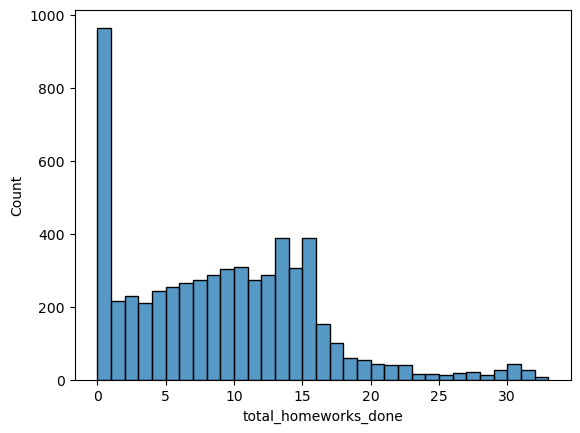

In [719]:
sns.histplot(df_result['total_homeworks_done'], binwidth=1)

The data in the columns with numeric data types (total_available_months, total_homeworks_done) do not raise any concerns.

## Task2. Let's divide all students into 6 waves:

Wave 0: Students who joined on or before the course start date.

In [731]:
wave_0 = df_result[df_result['course_access_at'] <= df_result['starts_at']]

Wave 1: Students who joined within 1 week after the course start date.

In [736]:
wave_1 = df_result[(df_result['course_access_at'] > df_result['starts_at']) & (df_result['course_access_at'] <= df_result['starts_at'] + pd.Timedelta(days=7))]

Wave 2: Students who joined within 1 to 2 weeks after the course start date.

In [760]:
wave_2 = df_result[(df_result['course_access_at'] > df_result['starts_at'] + pd.Timedelta(days=7)) & (df_result['course_access_at'] <= df_result['starts_at'] + pd.Timedelta(days=14))]

Wave 3: Students who joined within 2 to 3 weeks after the course start date.

In [765]:
wave_3 = df_result[(df_result['course_access_at'] > df_result['starts_at'] + pd.Timedelta(days=14)) & (df_result['course_access_at'] <= df_result['starts_at'] + pd.Timedelta(days=21))]

Wave 4: Students who joined within 3 to 4 weeks after the course start date.

In [770]:
wave_4 = df_result[(df_result['course_access_at'] > df_result['starts_at'] + pd.Timedelta(days=21)) & (df_result['course_access_at'] <= df_result['starts_at'] + pd.Timedelta(days=28))]

Wave 5: Students who joined more than 4 weeks after the course start date.

In [775]:
wave_5 = df_result[df_result['course_access_at'] > df_result['starts_at'] + pd.Timedelta(days=28)]

In [785]:
len(wave_5) + len(wave_4) + len(wave_3) + len(wave_2) + len(wave_1) + len(wave_0)

5881

It might be more convenient for subsequent analysis to combine the data into a single dataframe. To do this, we will add a column with a categorical variable to each individual dataframe.

In [792]:
wave_0 = wave_0.copy()
wave_1 = wave_1.copy()
wave_2 = wave_2.copy()
wave_3 = wave_3.copy()
wave_4 = wave_4.copy()
wave_5 = wave_5.copy()

In [794]:
wave_0['wave'] = 'wave_0'
wave_1['wave'] = 'wave_1'
wave_2['wave'] = 'wave_2'
wave_3['wave'] = 'wave_3'
wave_4['wave'] = 'wave_4'
wave_5['wave'] = 'wave_5'

Let's combine the dataframes:

In [797]:
all_waves = pd.concat([wave_0, wave_1, wave_2, wave_3, wave_4, wave_5], ignore_index=True)

In [801]:
all_waves.to_csv('all_waves.csv', index=False)